In [1]:
import tensorflow as tf
from IPython.display import clear_output
import matplotlib.pyplot as plt
import glob
import cv2
from skimage import io
from skimage.transform import resize
import numpy as np
from sklearn.model_selection import train_test_split
from tensorflow_examples.models.pix2pix import pix2pix

2022-10-31 14:58:35.886846: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-10-31 14:58:35.986459: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2022-10-31 14:58:36.011231: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2022-10-31 14:58:36.545817: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; 

In [2]:
%run utils
import utils

In [3]:
gpu_available = tf.config.list_physical_devices('GPU')
print(gpu_available)

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


2022-10-31 14:58:37.991322: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:966] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2022-10-31 14:58:38.000415: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:966] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2022-10-31 14:58:38.000838: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:966] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.


In [4]:
%load_ext tensorboard

### Prepare Dataset

In [5]:
naip_dir = "TIFimages/NAIP_2013"
mask_dir = "TIFimages/NLCD_2013"

In [6]:
def slice_image(img, desired_size):
    """Slice images into smaller pieces"""
    img = img / 255
    res = []
    h, w = img.shape[0], img.shape[1]
    dh, dw = desired_size
    num_rows, num_cols = h // dh, w // dw
    for i in range(num_rows):
        for j in range(num_cols):
            res.append(np.expand_dims(img[i*dh:i*dh+dh, j*dw:j*dw+dw], 2))
    return np.array(res)

In [7]:
def slice_mask(img, desired_size, remapping: dict):
    """slice NLCD imaegs into smaller pieces"""
    remapper = lambda x: remapping[x]
    img = np.vectorize(remapper)(img)
    res = []
    h, w = img.shape[0], img.shape[1]
    dh, dw = desired_size
    num_rows, num_cols = h // dh, w // dw
    for i in range(num_rows):
        for j in range(num_cols):
            res.append(np.expand_dims(img[i*dh:i*dh+dh, j*dw:j*dw+dw], axis=2))
    return np.array(res)

In [8]:
def remap_NLCD_labels(nlcd_map: dict):
    """remap NLCD labels from 17 classes to 5 classes (0 - 4)"""
    # first, remap MAPPING in utils.py 
    # to {"Water": 0, "Tree Canopy": 1, ...}
    mapping_remapped = {k: i for i, k in enumerate(utils.MAPPING.keys())}
    res = {}
    for k in nlcd_map.keys():
        res[k] = mapping_remapped[nlcd_map[k]]
    return res

In [9]:
nlcd_map = utils.create_direct_map()
remapping = remap_NLCD_labels(nlcd_map)
remapping

{0: 4,
 11: 0,
 12: 4,
 21: 2,
 22: 3,
 23: 3,
 24: 3,
 31: 3,
 41: 1,
 42: 1,
 43: 1,
 52: 1,
 71: 2,
 81: 2,
 82: 2,
 90: 1,
 95: 1}

In [10]:
img_sample = cv2.imread("TIFimages/NAIP_2013/1030_naip-2013.tif", 0)
print(img_sample.shape)
X = slice_image(img_sample, (128, 128))
print(X.shape)

(3880, 3880)
(900, 128, 128, 1)


In [11]:
mask_sample = io.imread("TIFimages/NLCD_2013/1030_nlcd-2013.tif")
print(mask_sample.shape)
y = slice_mask(mask_sample, (128, 128), remapping)
print(y.shape)

(3880, 3880)
(900, 128, 128, 1)


In [12]:
# dataset = tf.data.Dataset.from_tensor_slices((X, y)).batch(32)

In [13]:
# for naip, label in dataset:
#     print(naip.shape)
#     print(label.shape)
#     break

In [14]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42)

In [15]:
# for a in train_dataset:
#     print(a)
#     break

In [16]:
# X_dataset = tf.data.Dataset.from_generator(
#     read_naip_from_dir, 
#     args=[naip_dir, (128, 128)], 
#     output_types=tf.float32, 
#     output_shapes=(128, 128, 4))

In [17]:
# def read_nlcd_from_dir(dir: str, num: int, img_height, img_width):
#     image_files = glob.glob(f"{dir}/*.tif")
#     image_files.sort()
#     image_subset = image_files[:num]
#     image_list = [io.imread(x)[:img_height, :img_width] for x in image_subset]
#     image_list = np.array(image_list)
#     if image_list.ndim == 2:
#     	image_list = np.expand_dims(image_list, axis=3)
#     return image_list

In [18]:
# X = read_numpy_from_dir(naip_dir, num, image_size)
# y = read_numpy_from_dir(mask_dir, num, image_size)

In [19]:
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42)

In [20]:
# print(X_train[0].shape)
# print(X_train.shape)
# print(X_test.shape)

### Define U-net

In [21]:
from keras.models import Model
from keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, concatenate, Conv2DTranspose, BatchNormalization, Dropout, Lambda
from keras.optimizers import Adam
from keras.layers import Activation, MaxPool2D, Concatenate

In [22]:
# credit: https://www.youtube.com/watch?v=oBIkr7CAE6g&t=498s
def conv_block(input, num_filters):
    x = Conv2D(num_filters, 3, padding="same")(input)
    x = BatchNormalization()(x) # not in the original network
    x = Activation('relu')(x)
    
    x = Conv2D(num_filters, 3, padding="same")(x)
    x = BatchNormalization()(x) # not in the original network
    x = Activation('relu')(x)

    return x

# Encoder block: Conv block followed by maxpooling
def encoder_block(input, num_filters):
    x = conv_block(input, num_filters)
    p = MaxPool2D((2, 2))(x)
    return x, p


# Decoder block
# skip_features gets input from encoder for concatenation
def decoder_block(input, skip_features, num_filters):
    x = Conv2DTranspose(num_filters, (2, 2), strides=2, padding="same")(input)
    x = Concatenate()([x, skip_features])
    x = conv_block(x, num_filters)
    return x

# Build Unet
def build_unet(input_shape, n_classes):
    inputs = Input(input_shape)

    s1, p1 = encoder_block(inputs, 64)
    s2, p2 = encoder_block(p1, 128)
    s3, p3 = encoder_block(p2, 256)
    s4, p4 = encoder_block(p3, 512)

    b1 = conv_block(p4, 1025) # bridge

    d1 = decoder_block(b1, s4, 512)
    d2 = decoder_block(d1, s3, 256)
    d3 = decoder_block(d2, s2, 128)
    d4 = decoder_block(d3, s1, 64)

    if n_classes == 1:
        activation = "sigmoid"
    else:
        activation = "softmax"
    
    outputs = Conv2D(n_classes, 1, padding="same", activation=activation)(d4) 

    model = Model(inputs, outputs, name="U-Net")
    return model

### Train the model


In [23]:
CLASSES = len(utils.MAPPING)
CLASSES

5

In [24]:
# credit: https://github.com/tensorflow/tensorflow/issues/32875
# because the default implementation can't work, have to 
# implement ourselves
class UpdatedMeanIoU(tf.keras.metrics.MeanIoU):
    def __init__(self, y_true=None, y_pred=None, num_classes=None, name=None, dtype=None):
        super(UpdatedMeanIoU, self).__init__(num_classes=num_classes, name=name, dtype=dtype)

    def update_state(self, y_true, y_pred, sample_weight=None):
        y_pred = tf.math.argmax(y_pred, axis=-1)
        return super().update_state(y_true, y_pred, sample_weight)

In [25]:
class UpdatedIoU(tf.keras.metrics.IoU):
    def __init__(self, y_true=None, y_pred=None, num_classes=None, target_class_ids=None, name=None, dtype=None):
        super(UpdatedIoU, self).__init__(num_classes=num_classes, target_class_ids=target_class_ids, name=name, dtype=dtype)

    def update_state(self, y_true, y_pred, sample_weight=None):
        y_pred = tf.math.argmax(y_pred, axis=-1)
        return super().update_state(y_true, y_pred, sample_weight)

In [29]:
model = build_unet((128, 128, 1), n_classes=CLASSES)
model.compile(
    optimizer='adam', 
    loss=tf.keras.losses.SparseCategoricalCrossentropy(),
    metrics=["accuracy",
             UpdatedMeanIoU(num_classes=CLASSES),
             UpdatedIoU(num_classes=CLASSES, target_class_ids=[0, 1, 2, 3, 4])]
)
# model.summary()

In [30]:
history = model.fit(
    X_train, y_train,
    batch_size=16, 
    verbose=1, 
    epochs=10, 
    validation_data=(X_test, y_test), 
    shuffle=False)

Epoch 1/10


2022-10-31 14:59:18.392266: I tensorflow/stream_executor/cuda/cuda_dnn.cc:384] Loaded cuDNN version 8100
2022-10-31 14:59:19.297277: W tensorflow/stream_executor/gpu/asm_compiler.cc:111] *** WARNING *** You are using ptxas 10.1.243, which is older than 11.1. ptxas before 11.1 is known to miscompile XLA code, leading to incorrect results or invalid-address errors.

You may not need to update to CUDA 11.1; cherry-picking the ptxas binary is often sufficient.
2022-10-31 14:59:19.298491: W tensorflow/stream_executor/gpu/asm_compiler.cc:230] Falling back to the CUDA driver for PTX compilation; ptxas does not support CC 8.6
2022-10-31 14:59:19.298517: W tensorflow/stream_executor/gpu/asm_compiler.cc:233] Used ptxas at ptxas
2022-10-31 14:59:19.298560: W tensorflow/stream_executor/gpu/redzone_allocator.cc:314] UNIMPLEMENTED: ptxas ptxas too old. Falling back to the driver to compile.
Relying on driver to perform ptx compilation. 
Modify $PATH to customize ptxas location.
This message will be 

51/51 [==============================] - 27s 321ms/step - loss: 0.6529 - accuracy: 0.8571 - updated_mean_io_u_1: 0.2646 - updated_io_u_1: 0.2646 - val_loss: 167.0260 - val_accuracy: 0.2018 - val_updated_mean_io_u_1: 0.0416 - val_updated_io_u_1: 0.0416
Epoch 2/10
51/51 [==============================] - 11s 224ms/step - loss: 0.3766 - accuracy: 0.8886 - updated_mean_io_u_1: 0.2816 - updated_io_u_1: 0.2816 - val_loss: 0.8109 - val_accuracy: 0.7875 - val_updated_mean_io_u_1: 0.2625 - val_updated_io_u_1: 0.2625
Epoch 3/10
51/51 [==============================] - 11s 223ms/step - loss: 0.3187 - accuracy: 0.8918 - updated_mean_io_u_1: 0.4738 - updated_io_u_1: 0.4738 - val_loss: 1.0390 - val_accuracy: 0.7875 - val_updated_mean_io_u_1: 0.2625 - val_updated_io_u_1: 0.2625
Epoch 4/10
51/51 [==============================] - 11s 223ms/step - loss: 0.2928 - accuracy: 0.8966 - updated_mean_io_u_1: 0.4792 - updated_io_u_1: 0.4792 - val_loss: 1.0555 - val_accuracy: 0.7875 - val_updated_mean_io_u_1: 0

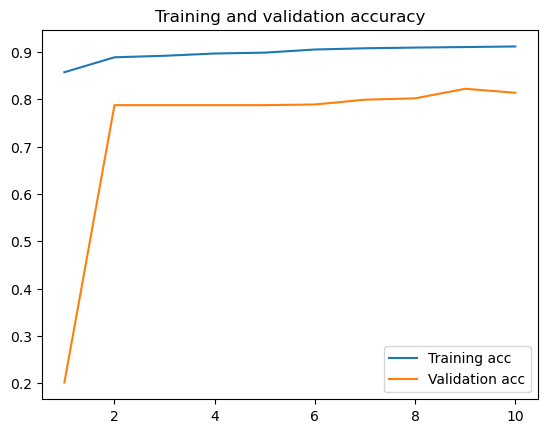

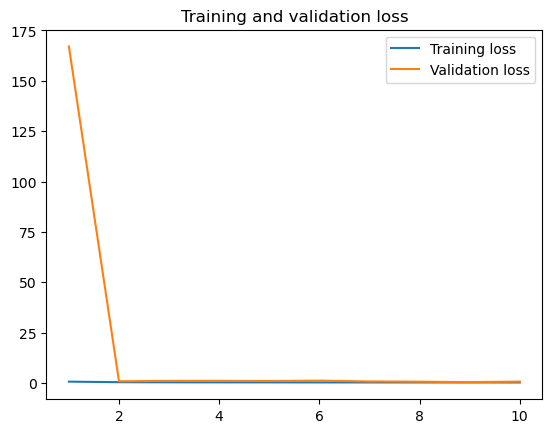

In [31]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, label='Training acc')
plt.plot(epochs, val_acc, label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, label='Training loss')
plt.plot(epochs, val_loss, label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [ ]:
# file_writer = tf.summary.create_file_writer('logs')

In [ ]:
# %tensorboard --logdir logs

In [33]:
history.history['updated_mean_io_u_1']

[0.26463621854782104,
 0.2816423773765564,
 0.473811537027359,
 0.4791598618030548,
 0.4830106198787689,
 0.49141451716423035,
 0.49619260430336,
 0.49857059121131897,
 0.5014808773994446,
 0.5030924677848816]